# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise a.
Derive the product-form solution for the stationary distribution of this Jackson network and determine the stability conditions (consult Lecture on 30 October).

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [1]:
from scipy import stats
from collections import deque
import heapq
import numpy as np
import matplotlib.pyplot as plt

verbose = True

In [2]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def leaveSystem(self):
        self.location = 'out'
        self.serviceTime = -1

In [3]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time
        
    def __str__(self):
        s = ('Arrival', 'Departure')
        return self.type + " of customer " + str(self.customer) + ' at t = ' + str(self.time)


In [4]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)
    
    def isEmpty(self):
        return len(self.events) == 0
        
    def __str__(self):
        # Note that if you print self.events, it would not appear to be sorted
        # (although they are sorted internally).
        # For this reason we use the function 'sorted'
        s = ''
        sortedEvents = sorted(self.events)
        for e in sortedEvents :
            s += str(e) + '\n'
        return s


In [5]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        self.number_of_customers = 0 # Number of customers at this server, not including queue
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

In [6]:
class SimulationResults:
    
    def __init__(self):
        self.results = {
            'blocking_probability': {'high': 0,
                                     'low': 0,
                                     'total': 0},
            'waiting_probability_needy': {'high_priority': 0,
                                          'low_priority': 0},
            'mean_time_in_system': {'high_priority': 0,
                                    'low_priority': 0},
            'mean_waiting_time_in_system': {'high_priority': 0,
                                            'low_priority': 0},
            'mean_waiting_time_to_enter_system': {'high_priority': 0,
                                                  'low_priority': 0},
            'mean_queue_length': {'holding_high_priority': 0,
                                  'holding_low_priority': 0,
                                  'needy': 0},
            'utilisation_needy': 0
        }
        self.results = {}
        
        self.number_of_arrivals = {'high': 0, 'low': 0}
        self.number_of_arrivals_waiting = {'high': 0, 'low': 0}
        
        self.total_needy_queue_length = 0
        
    def register_arrival(self, priority, waiting=False):
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1
    
    def calculate_blocking_probability(self):
        # number of arrivals that have to wait in holding / total number of arrivals
        
        self.results['blocking_probability'] = {priority : self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
                                               for priority in ('high','low')}
        self.results['blocking_probability']['total'] = sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
        
        
    def update_total_needy_queue_length(self, length):
        self.total_needy_queue_length += length
        

In [7]:
class Network:
    
    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T, burn_in_period=None):
        
        # If burn-in period is not specified, take 20% of T, rounded down
        if burn_in_period is None:
            burn_in_period = T // 5
        
        t = 0 # initialise time
        total_needy_queue=0
        
        fes = FES()                  
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent) # schedule first arrival event
        
        # if number people < N: go to needy queue
        while t < T:
            
            burn_in = (t < burn_in_period)
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                     # customer associated with this event
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)
            
            # Update total number of people that had to wait in the needy queue
            if not burn_in:
                self.simresults.update_total_needy_queue_length(length=len(queue_needy))
            
            if e.type == 'ARRIVAL':
                if c1.location == 'holding':
                    
                    # Someone arrive
                    if number_in_system < self.N:
                        
                        # Admit this customer
                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            # Admit this customer
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Queue in needy, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)

                        if not burn_in:
                            self.simresults.register_arrival(priority=c1.priority)
                            
                    else:
                        # else: add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        if not burn_in:
                            self.simresults.register_arrival(priority=c1.priority, waiting=True)

                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, t + c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                    
                
            elif e.type == 'DEPARTURE':
                # Then it's a departure
                
                # Check if departed from needy or from content
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    
                    # Update number of customers at needy server
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        c1.leaveSystem() # Set c1.location to out and c1.serviceTime to -1
                        
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                        else:
                            pass
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
        return "Simulation finished"

In [8]:
np.random.seed(1)
T = 1000

# Initialise arguments
lambda_L = 0.5
lambda_H = 0.25
nrServers = 2
N = 5
p = 0.4

mu = 1
delta = 1

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=float(1/delta))

sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)

sim.simulate(T, 100)

'Simulation finished'

In [9]:
sim.simresults.number_of_arrivals

{'high': 254, 'low': 433}

In [10]:
sim.simresults.number_of_arrivals_waiting

{'high': 23, 'low': 50}

In [11]:
sim.simresults.calculate_blocking_probability()
print("Blocking probability:", sim.simresults.results['blocking_probability'])

q_n = sim.simresults.total_needy_queue_length
print("Total needy queue length:", q_n)
print("Mean needy queue length:", q_n / (T*13))

Blocking probability: {'high': 0.09055118110236221, 'low': 0.11547344110854503, 'total': 0.10625909752547306}
Total needy queue length: 1711
Mean needy queue length: 0.1316153846153846


In [12]:
lambda_H

0.25

## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [13]:
lambda_H, nrServers*mu-lambda_H, lambda_L

(0.25, 1.75, 0.5)

In [14]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)
runs = 10
T = 1000

# Specify which values for lambda_L to test
lambda_H_temp = 1/100
lambda_L_array = np.linspace(lambda_H_temp, (1-p)*nrServers*mu-lambda_H_temp, runs)
lambda_L_temp = lambda_L

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_L = lambda_L_array[i]
    sim = Network(lambda_L, lambda_H_temp, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_L equal to", lambda_L)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
# Reset lambda_L
lambda_L = lambda_L_temp

Probability for lambda_L equal to 0.01
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.1411111111111111
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.2722222222222222
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.4033333333333333
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.5344444444444444
Blocking probability: {'high': 0.0, 'low': 0.004694835680751174, 'total': 0.0045871559633027525}

Probability for lambda_L equal to 0.6655555555555555
Blocking probability: {'high': 0.16666666666666666, 'low': 0.05390334572490706, 'total': 0.05514705882352941}

Probability for lambda_L equal to 0.7966666666666666
Blocking probability: {'high': 0.18181818181818182, 'low': 0.19090909090909092, 'total': 0.19076005961251863}

Probability for lambda_L equal to 0.9277777777777777
Blocking probabili

In [15]:
sim.simresults.number_of_arrivals, sum(sim.simresults.number_of_arrivals.values())

({'high': 2, 'low': 962}, 964)

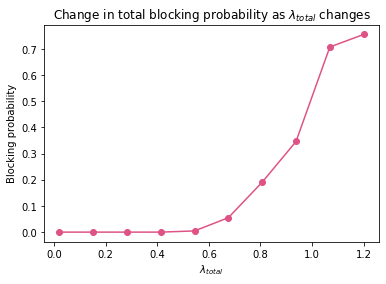

In [16]:
plt.plot(lambda_L_array+lambda_H_temp, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\lambda_{total}$')
plt.ylabel('Blocking probability')
plt.title('Change in total blocking probability as $\lambda_{total}$ changes')
plt.show()

In [17]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Specify which values for lambda_H to test
lambda_L_temp = 1/100
lambda_H_array = np.linspace(lambda_L_temp, nrServers*mu-lambda_L_temp, runs)
lambda_H_temp = lambda_H

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_H = lambda_H_array[i]
    sim = Network(lambda_L_temp, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_H equal to", lambda_H)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
lambda_H = lambda_H_temp

Probability for lambda_H equal to 0.01
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_H equal to 0.23
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_H equal to 0.45
Blocking probability: {'high': 0.008771929824561403, 'low': 0.0, 'total': 0.008595988538681949}

Probability for lambda_H equal to 0.67
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_H equal to 0.89
Blocking probability: {'high': 0.12973760932944606, 'low': 0.5, 'total': 0.1318840579710145}

Probability for lambda_H equal to 1.11
Blocking probability: {'high': 0.8324022346368715, 'low': 1.0, 'total': 0.8337028824833703}

Probability for lambda_H equal to 1.33
Blocking probability: {'high': 1.0, 'low': 1.0, 'total': 1.0}

Probability for lambda_H equal to 1.55
Blocking probability: {'high': 1.0, 'low': 1.0, 'total': 1.0}

Probability for lambda_H equal to 1.77
Blocking probability: {'high': 1.0, 'low': 1.0, 't

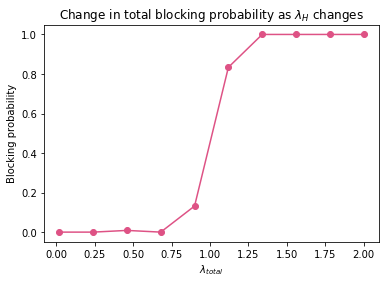

In [18]:
plt.plot(lambda_H_array+lambda_L_temp, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\lambda_{total}$')
plt.ylabel('Blocking probability')
plt.title('Change in total blocking probability as $\lambda_H$ changes')
plt.show()

In [19]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Specify which values for lambda_H to test
delta_temp = delta
delta_array = np.linspace(4, 4*nrServers*mu, runs)

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    delta = delta_array[i]
    servDist_content = stats.expon(scale=float(1/delta))
    
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for delta equal to", delta)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']

# Reset to original values
delta = delta_temp
servDist_content = stats.expon(scale=float(1/delta))

Probability for delta equal to 4.0
Blocking probability: {'high': 0.11158798283261803, 'low': 0.1378504672897196, 'total': 0.12859304084720122}

Probability for delta equal to 4.444444444444445
Blocking probability: {'high': 0.05527638190954774, 'low': 0.04433497536945813, 'total': 0.047933884297520664}

Probability for delta equal to 4.888888888888889
Blocking probability: {'high': 0.09183673469387756, 'low': 0.1044776119402985, 'total': 0.10033444816053512}

Probability for delta equal to 5.333333333333333
Blocking probability: {'high': 0.12138728323699421, 'low': 0.11421911421911422, 'total': 0.11627906976744186}

Probability for delta equal to 5.777777777777778
Blocking probability: {'high': 0.08839779005524862, 'low': 0.10256410256410256, 'total': 0.09807355516637478}

Probability for delta equal to 6.222222222222222
Blocking probability: {'high': 0.02857142857142857, 'low': 0.04221635883905013, 'total': 0.03735144312393888}

Probability for delta equal to 6.666666666666666
Blocki

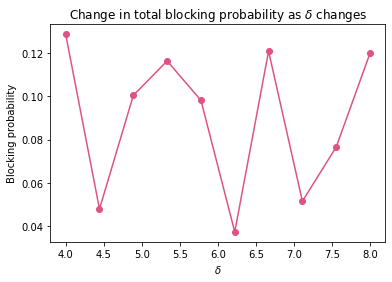

In [20]:
plt.plot(delta_array, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
plt.title('Change in total blocking probability as $\delta$ changes')
plt.show()

In [21]:
# Changing p (comparing the needy queue length)
np.random.seed(1)

# Specify which values for p to test
p_array = np.linspace(0.01, 0.9, runs)

mean_queue_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    q_n = sim.simresults.total_needy_queue_length 
    q_n_mean = q_n / (T *13)
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", q_n_mean)
        print("")
    
    mean_queue_length[i] = q_n_mean

Probability of not leaving system equal to 0.01
Mean queue length:  0.023384615384615386

Probability of not leaving system equal to 0.10888888888888888
Mean queue length:  0.03876923076923077

Probability of not leaving system equal to 0.20777777777777778
Mean queue length:  0.04715384615384616

Probability of not leaving system equal to 0.30666666666666664
Mean queue length:  0.07038461538461538

Probability of not leaving system equal to 0.40555555555555556
Mean queue length:  0.17976923076923076

Probability of not leaving system equal to 0.5044444444444445
Mean queue length:  0.19407692307692306

Probability of not leaving system equal to 0.6033333333333333
Mean queue length:  0.5013076923076923

Probability of not leaving system equal to 0.7022222222222222
Mean queue length:  0.5968461538461538

Probability of not leaving system equal to 0.8011111111111111
Mean queue length:  0.5453846153846154

Probability of not leaving system equal to 0.9
Mean queue length:  0.5524615384615384

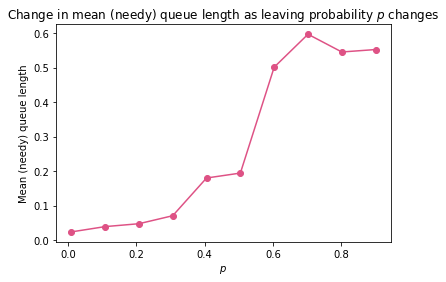

In [22]:
plt.plot(p_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean (needy) queue length')
plt.title('Change in mean (needy) queue length as leaving probability $p$ changes')
plt.show()

## Exercise d.
Investigate the difference in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?